In [41]:
from oLIMpus import * 
import matplotlib.pyplot as plt
import powerbox as pb

from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()


In [8]:
ZMIN = 5.
RSD_MODE = 0

In [34]:
class run_oLIMpus:

    def __init__(self, LINE_MODEL = 'Yang24', _R = 2., shot_noise= False, quadratic=True, astromodel=1):

        self.UP = User_Parameters(
            precisionboost= 1.0, 
            FLAG_FORCE_LINEAR_CF= 0, 
            MIN_R_NONLINEAR= 0.5, 
            MAX_R_NONLINEAR= 200.0,
            FLAG_DO_DENS_NL= False, 
            FLAG_WF_ITERATIVE= True
            )

        CosmoParams_input = Cosmo_Parameters_Input(HMF_CHOICE='ST')
        self.CP, self.ClassyC, self.zeus_corr, self.HMFcl =  cosmo_wrapper(self.UP, CosmoParams_input)

        self.AP = zeus21.Astro_Parameters(self.UP, self.CP, USE_POPIII = False, USE_LW_FEEDBACK = False, astromodel=astromodel)

        LineParams_Input_val = LineParams_Input(
            LINE = 'OIII', # which line
            LINE_MODEL = LINE_MODEL, # model of the line luminosity
            OBSERVABLE_LIM = 'Inu', # observe intensity in Jy/sr or mK
            _R = _R, # resolution for smoothing
            sigma_LSFR = 0., # stochasticity in the L-SFR relation
            shot_noise = shot_noise, # add shot noise to the power spectrum
            Eulerian = True, # Eulerian or Lagrangian space, MOVE TO USER PARAMS
            quadratic_lognormal = quadratic # use 1st or 2nd order in the SFRD and line lognormal approximation MOVE TO USER PARAMS
        )

        self.LP = Line_Parameters(LineParams_Input_val,self.UP)
        
        self.LIM_coeff = get_LIM_coefficients(self.LP, self.AP, self.CP, self.HMFcl, self.UP, ZMIN)

        self.LIM_corr = Correlations_LIM(self.LP, self.CP, self.ClassyC)

        self.LIM_pk = Power_Spectra_LIM(self.LIM_corr, self.LIM_coeff, self.LP, self.CP, self.UP, RSD_MODE)


In [35]:
SFRD_model = run_oLIMpus(LINE_MODEL = 'SFRD', _R = 2., shot_noise= False, quadratic=False, astromodel=1)
SFRD_model_0 = run_oLIMpus(LINE_MODEL = 'SFRD', _R = 2., shot_noise= False, quadratic=False, astromodel=0)

OIII_lin_model = run_oLIMpus(LINE_MODEL = 'Yang24', _R = 2., shot_noise= False, quadratic=False, astromodel=1)
OIII_model = run_oLIMpus(LINE_MODEL = 'Yang24', _R = 2., shot_noise= True, quadratic=True, astromodel=1)

/mnt/DATA/coding/21cm/oLIMpus/oLIMpus/LIM_modeling.py:220: RuntimeWarning: divide by zero encountered in log10
  log10_L = np.log10(dotM)
/mnt/DATA/coding/21cm/oLIMpus/oLIMpus/LIM_modeling.py:239: RuntimeWarning: divide by zero encountered in power
  L_line = 2. * N * dotM / ((dotM / SFR1)**(-alpha) + (dotM / SFR1)**beta)
/mnt/DATA/coding/21cm/oLIMpus/oLIMpus/LIM_modeling.py:241: RuntimeWarning: divide by zero encountered in log10
  log10_L = np.log10(L_line)


/tmp/ipykernel_97247/3116779248.py:17: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(M,np.log10(SFR[z_id,:,0]),label='exp accretion')
/tmp/ipykernel_97247/3116779248.py:18: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(M,np.log10(SFR0[z_id,:,0]), label='21cmfast-like')


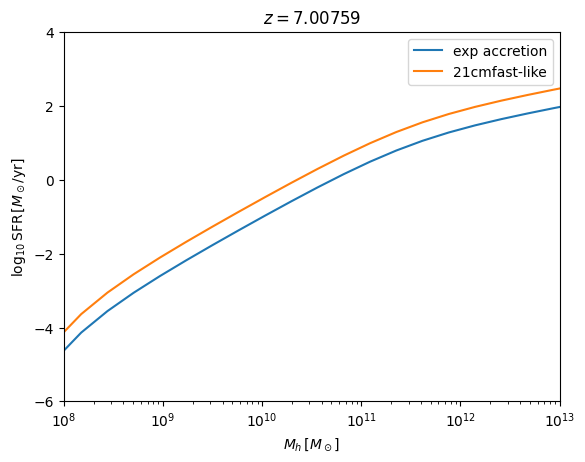

/tmp/ipykernel_97247/3116779248.py:30: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(SFR[z_id,:,0]),np.log10(OIII[z_id,:,0]),label='exp accretion')
/tmp/ipykernel_97247/3116779248.py:31: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(SFR0[z_id,:,0]),np.log10(OIII0[z_id,:,0]),label='21cmFAST-like')


Text(0.5, 1.0, '${\\rm OIII},\\,$$z=7.00759$')

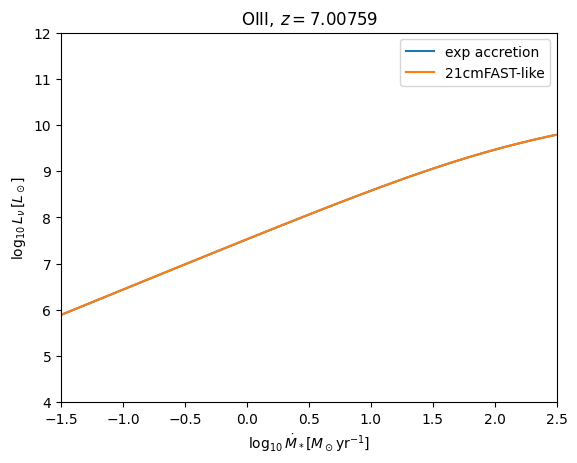

In [36]:
M = SFRD_model.HMFcl.Mhtab

Nsigmad = 1.0 #how many sigmas we explore
Nds = 3 #how many deltas
deltatab_norm = np.linspace(-Nsigmad,Nsigmad,Nds)
_dlogzint_target = 0.02/SFRD_model.UP.precisionboost
Nzintegral = np.ceil(1.0 + np.log(ZMAX_INTEGRAL/ZMIN)/_dlogzint_target).astype(int)
dlogzint = np.log(ZMAX_INTEGRAL/ZMIN)/(Nzintegral-1.0) #exact value rather than input target above
zintegral = np.logspace(np.log10(ZMIN), np.log10(ZMAX_INTEGRAL), Nzintegral)

zArray_LIM, mArray_LIM, deltaNormArray_LIM = np.meshgrid(zintegral, M, deltatab_norm, indexing = 'ij', sparse = True)

SFR = LineLuminosity(False, SFRD_model.LP, SFRD_model.AP, SFRD_model.CP, SFRD_model.HMFcl, mArray_LIM, zArray_LIM)
SFR0 = LineLuminosity(False, SFRD_model_0.LP, SFRD_model_0.AP, SFRD_model_0.CP, SFRD_model_0.HMFcl, mArray_LIM, zArray_LIM)

z_id = 17
plt.semilogx(M,np.log10(SFR[z_id,:,0]),label='exp accretion')
plt.semilogx(M,np.log10(SFR0[z_id,:,0]), label='21cmfast-like')
plt.ylim(-6,4)
plt.xlim(1e8,1e13)
plt.xlabel(r'$M_h\,[M_\odot]$')
plt.ylabel(r'$\log_{10}{\rm SFR}\,[M_\odot/{\rm yr}]$')
plt.title(r'$z=%g$'%zintegral[z_id])
plt.legend()
plt.show()

OIII = LineLuminosity(SFR, OIII_model.LP, OIII_model.AP, OIII_model.CP, OIII_model.HMFcl, mArray_LIM, zArray_LIM)
OIII0 = LineLuminosity(SFR0, OIII_model.LP, SFRD_model_0.AP, OIII_model.CP, OIII_model.HMFcl, mArray_LIM, zArray_LIM)

plt.plot(np.log10(SFR[z_id,:,0]),np.log10(OIII[z_id,:,0]),label='exp accretion')
plt.plot(np.log10(SFR0[z_id,:,0]),np.log10(OIII0[z_id,:,0]),label='21cmFAST-like')
plt.ylim(4,12)
plt.legend()
plt.xlim(-1.5,2.5)
plt.xlabel(r'$\log_{10} \dot{M}_* [M_\odot{\rm yr^{-1}}]$')
plt.ylabel(r'$\log_{10} L_\nu\,[L_\odot]$')
plt.title(r'${\rm OIII},\,$' + r'$z=%g$'%zintegral[z_id])


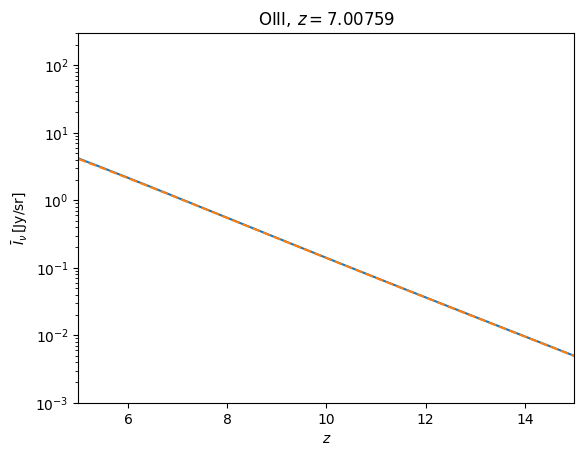

In [37]:
plt.semilogy(zintegral,OIII_lin_model.LIM_coeff.Inu_bar,label='linear')
plt.semilogy(zintegral,OIII_model.LIM_coeff.Inu_bar,ls='--',label='quadratic')
plt.title(r'${\rm OIII},\,$' + r'$z=%g$'%zintegral[z_id])
plt.xlabel(r'$z$')
plt.ylabel(r'$\bar{I}_\nu\,[{\rm Jy/sr}]$')
plt.xlim(5,15)
plt.ylim(1e-3,3e2)
plt.show()

Text(0, 0.5, '$\\xi$')

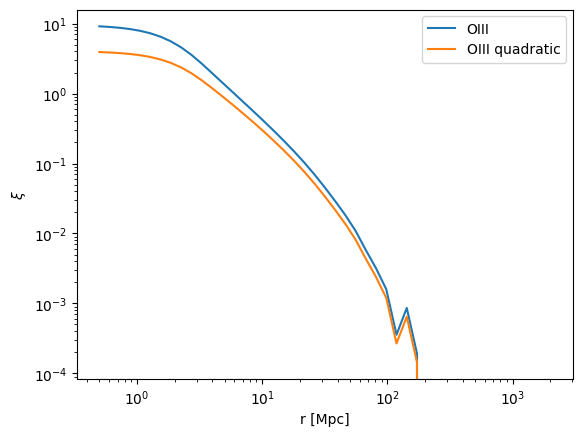

In [38]:
plt.loglog(OIII_model.CP._Rtabsmoo,OIII_lin_model.LIM_pk._xiR0_LIM[z_id], label= 'OIII')
plt.loglog(OIII_model.CP._Rtabsmoo,OIII_model.LIM_pk._xiR0_LIM[z_id], label= 'OIII quadratic',ls='-')
#plt.loglog(CosmoParams_use._Rtabsmoo,OIII_Pk._xiR0_deltaLIM[z_id])
plt.legend()
plt.xlabel(r'r [Mpc]')
plt.ylabel(r'$\xi$')

In [ ]:
zeus_coeff = get_T21_coefficients(OIII_model.UP, OIII_model.CP, OIII_model.ClassyC, OIII_model.AP, OIII_model.HMFcl, zmin=ZMIN)

Lbox = 100
Nbox = 100

test_box = CoevalBox_percell(OIII_model.LIM_coeff, OIII_model.LIM_corr,OIII_model.LIM_pk,zeus_coeff,OIII_model.LP,OIII_model.AP, OIII_model.CP, OIII_model.HMFcl,7.,Lbox,Nbox)

/mnt/DATA/coding/21cm/oLIMpus/oLIMpus/LIM_modeling.py:239: RuntimeWarning: divide by zero encountered in power
  L_line = 2. * N * dotM / ((dotM / SFR1)**(-alpha) + (dotM / SFR1)**beta)
/mnt/DATA/coding/21cm/oLIMpus/oLIMpus/LIM_modeling.py:241: RuntimeWarning: divide by zero encountered in log10
  log10_L = np.log10(L_line)


In [ ]:
k_bins = np.logspace(np.log10(2*np.pi/Lbox),np.log10(2*np.pi/Lbox*Nbox),10)
print('kmin = ' + str(k_bins[0]))
print('kmax = ' + str(k_bins[-1]))

pk_LIM_percell, kLIM = res = pb.get_power(
            deltax = test_box.Inu_box,
            boxlength=Lbox,
            bins = k_bins, )


kmin = 0.06283185307179588
kmax = 6.283185307179586


Text(0, 0.5, '$\\Delta^2$')

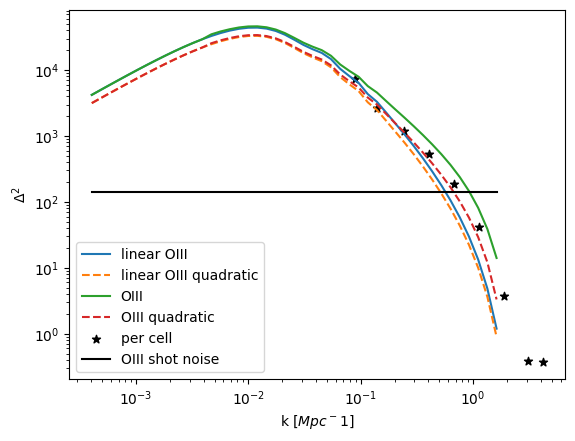

In [63]:
plt.loglog(OIII_model.LIM_corr._klistCF,OIII_lin_model.LIM_pk._Pk_LIM_lin[z_id] , label='linear OIII' )
plt.loglog(OIII_model.LIM_corr._klistCF,OIII_model.LIM_pk._Pk_LIM_lin[z_id] , label = 'linear OIII quadratic',ls = '--')
plt.loglog(OIII_model.LIM_corr._klistCF,(OIII_lin_model.LIM_pk._Pk_LIM[z_id]) , label='OIII' )
plt.loglog(OIII_model.LIM_corr._klistCF,(OIII_model.LIM_pk._Pk_LIM[z_id])  , 
label = 'OIII quadratic', ls = '--')

plt.scatter(kLIM,pk_LIM_percell,marker='*',color='k',label='per cell')

plt.loglog(OIII_model.LIM_corr._klistCF,(OIII_model.LIM_pk.P_shot_noise[z_id]), 
label = 'OIII shot noise',color='k')

plt.legend()
plt.xlabel(r'k [$Mpc^-1$]')
plt.ylabel(r'$\Delta^2$')

In [ ]:
boxes = CoevalBox_LIM_analytical(OIII_lin_model.LIM_coeff,OIII_lin_model.LIM_corr,OIII_lin_model.LIM_pk,OIII_lin_model.LP,7.,Lbox,Nbox)
boxes_quad_shot = CoevalBox_LIM_analytical(OIII_model.LIM_coeff,OIII_model.LIM_corr, OIII_model.LIM_pk,OIII_model.LP,7.,Lbox,Nbox)

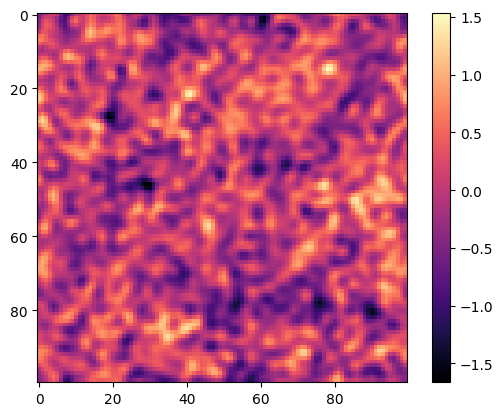

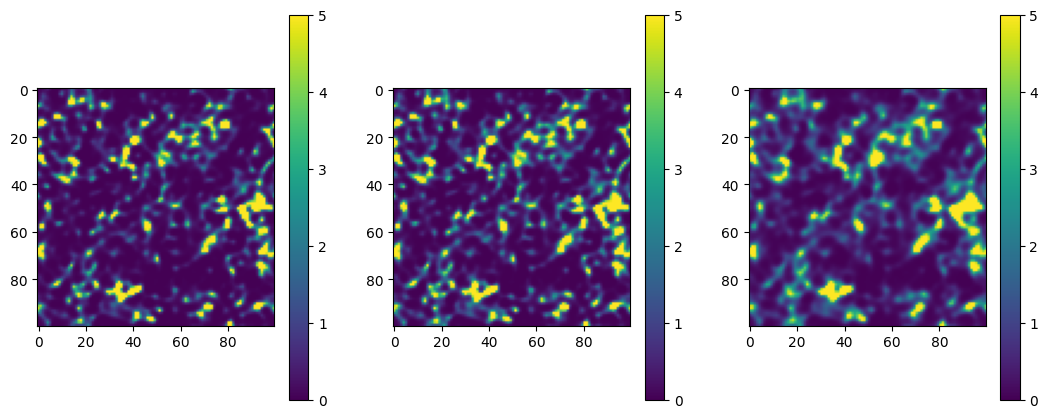

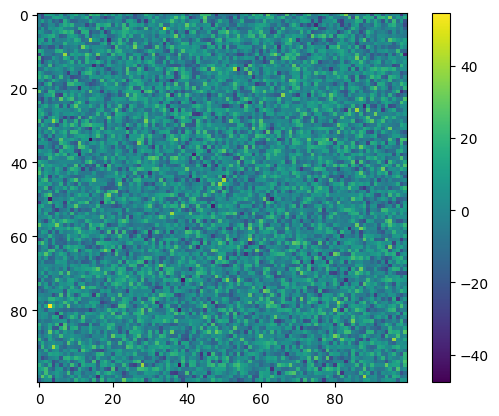

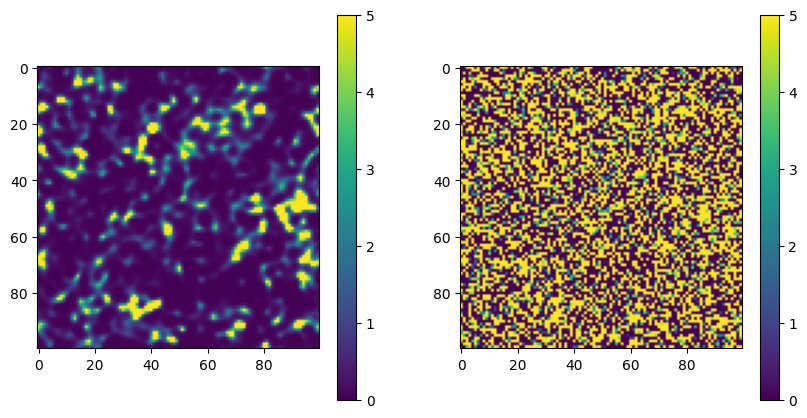

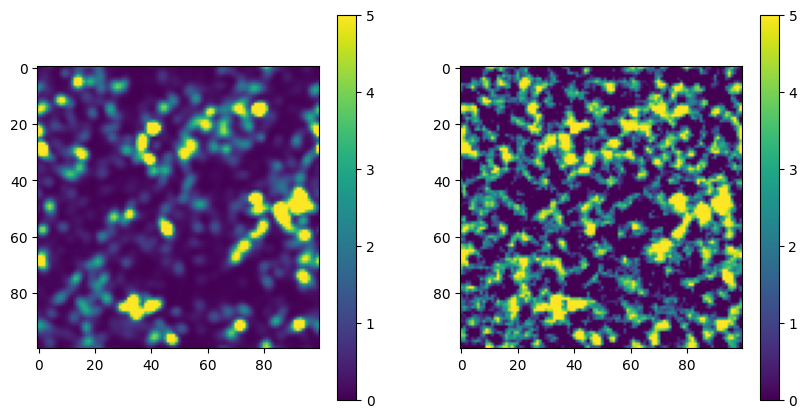

In [55]:
plt.imshow(boxes.delta_box[0],cmap='magma')
plt.colorbar()
plt.show()

plt.figure(figsize=(13,5))
plt.subplot(131)
plt.imshow(boxes.Inu_box_noiseless[0],vmin=0,vmax=5)
plt.colorbar()
plt.subplot(132)
plt.imshow(boxes_quad_shot.Inu_box_noiseless[0],vmin=0,vmax=5)
plt.colorbar()
plt.subplot(133)
plt.imshow(test_box.Inu_box[0],vmin=0,vmax=5)
plt.colorbar()
plt.show()

plt.imshow(boxes_quad_shot.shotnoise_box[0],)
plt.colorbar()
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(boxes.Inu_box[0],vmin=0,vmax=5)
plt.colorbar()
plt.subplot(122)
plt.imshow(boxes_quad_shot.Inu_box[0],vmin=0,vmax=5)
plt.colorbar()
plt.show()


plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(boxes.Inu_box_smooth[0],vmin = 0,vmax=5)
plt.colorbar()
plt.subplot(122)
plt.imshow(boxes_quad_shot.Inu_box_smooth[0],vmin=0,vmax=5)
plt.colorbar()
plt.show()

kmin = 0.06283185307179588
kmax = 6.283185307179586


(0.01, 3)

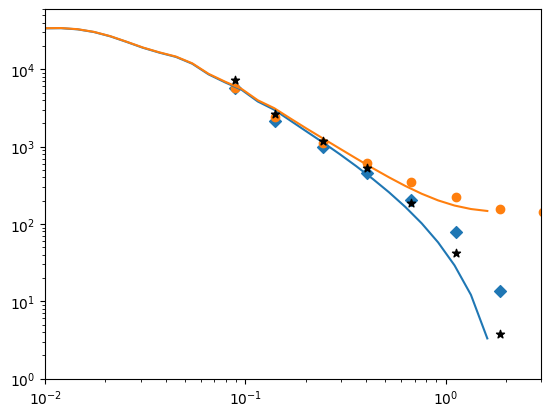

In [ ]:

k_bins = np.logspace(np.log10(2*np.pi/Lbox),np.log10(2*np.pi/Lbox*Nbox),10)
print('kmin = ' + str(k_bins[0]))
print('kmax = ' + str(k_bins[-1]))

pk_LIM_noiseless, kLIM = res = pb.get_power(
            deltax = boxes_quad_shot.Inu_box_noiseless,
            boxlength=Lbox,
            bins = k_bins, )

pk_LIM, kLIM = res = pb.get_power(
            deltax = boxes_quad_shot.Inu_box,
            boxlength=Lbox,
            bins = k_bins, )


plt.scatter(kLIM,pk_LIM_noiseless,marker='D',)
plt.scatter(kLIM,pk_LIM,marker='o',)
plt.scatter(kLIM,pk_LIM_percell,marker='*',color='k',zorder=10)
plt.loglog(OIII_model.LIM_pk.klist_PS,OIII_model.LIM_pk._Pk_LIM[z_id])
plt.loglog(OIII_model.LIM_pk.klist_PS,OIII_model.LIM_pk._Pk_LIM_tot[z_id])
plt.ylim(1,6e4)
plt.xlim(1e-2,3)

(array([6.114e+03, 2.654e+03, 6.760e+02, 2.620e+02, 1.160e+02, 8.100e+01,
        3.200e+01, 2.400e+01, 1.900e+01, 1.000e+01, 7.000e+00, 1.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-1.        ,  0.72222222,  2.44444444,  4.16666667,  5.88888889,
         7.61111111,  9.33333333, 11.05555556, 12.77777778, 14.5       ,
        16.22222222, 17.94444444, 19.66666667, 21.38888889, 23.11111111,
        24.83333333, 26.55555556, 28.27777778, 30.        ]),
 <BarContainer object of 18 artists>)

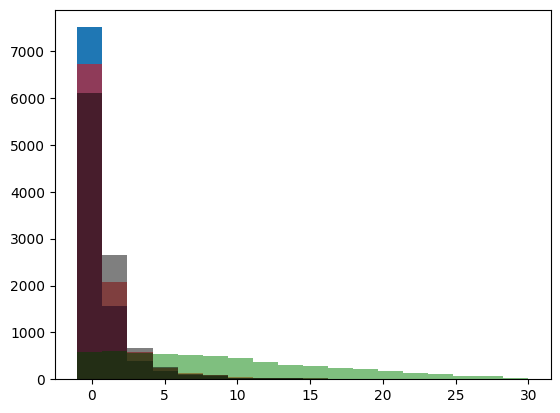

In [59]:
plt.hist(boxes.Inu_box[0].flatten(),bins = np.linspace(-1,30,19),label='linear')
plt.hist(boxes_quad_shot.Inu_box_noiseless[0].flatten(),bins = np.linspace(-1,30,19),color='r',alpha=0.5,label='quadratic')
plt.hist(boxes_quad_shot.Inu_box[0].flatten(),bins = np.linspace(-1,30,19),color='g',alpha=0.5,label='quadratic+shot noise')
plt.hist(test_box.Inu_box[0].flatten(),bins = np.linspace(-1,30,19),color='k',alpha=0.5,label='per cell')
